## Mount Colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/AirBnb_Case_Study

/content/drive/MyDrive/AirBnb_Case_Study


In [9]:
!ls

listings.csv  model.png


## Import Libraries

In [10]:
import string
import re
import nltk
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
import xgboost
from xgboost import plot_importance, XGBRegressor

from wordcloud import WordCloud,STOPWORDS

## Data Exploration

In [11]:
# load the data
df1 = pd.read_csv("listings.csv")
df1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,138592,Home in San Francisco · ★4.91 · 4 bedrooms · 4...,648553,Julie & Brad,NaN,Noe Valley,37.75635,-122.42864,Entire home/apt,1250,5,34,2023-08-18,0.23,1,80,2,Pending Application
1,474107,Home in San Francisco · ★4.91 · 2 bedrooms · 2...,2318089,Inés,NaN,Excelsior,37.72369,-122.42865,Private room,79,2,149,2023-11-14,1.92,1,196,20,STR-0007772
2,487019,Rental unit in San Francisco · ★4.53 · 3 bedro...,2410550,Cecile,NaN,Potrero Hill,37.75622,-122.39821,Entire home/apt,249,5,36,2023-07-18,0.26,1,202,7,STR-0001599
3,487499,Rental unit in San Francisco · ★4.78 · 1 bedro...,1682183,Daniel,NaN,Mission,37.75884,-122.42232,Entire home/apt,125,30,196,2023-11-04,1.41,1,149,4,NaN
4,1163946,Condo in San Francisco · 2 bedrooms · 2 beds ·...,1918239,Jen,NaN,Mission,37.76111,-122.42082,Entire home/apt,70,30,2,2016-10-07,0.02,1,0,0,NaN


In [12]:
# take information about dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8056 entries, 0 to 8055
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8056 non-null   int64  
 1   name                            8056 non-null   object 
 2   host_id                         8056 non-null   int64  
 3   host_name                       8055 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   8056 non-null   object 
 6   latitude                        8056 non-null   float64
 7   longitude                       8056 non-null   float64
 8   room_type                       8056 non-null   object 
 9   price                           8056 non-null   int64  
 10  minimum_nights                  8056 non-null   int64  
 11  number_of_reviews               8056 non-null   int64  
 12  last_review                     61

From the above dataset information, it is seen that there are null values present in the dataset. So, the below code checks the nulls in each column.

In [13]:
# check how many nulls are there in the dataframe

df1.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            1
neighbourhood_group               8056
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1884
reviews_per_month                 1884
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           2965
dtype: int64

From the above result, it is seen that there are all null values in the _neighbourhood_group_ column. So, this coulmn can be dropped.

The other columns like _host_name_, _last_review_, _reviews_per_month_ and _license_ are filled with relevant values.

In [14]:
# check the missing values in percentage
missing_values = df1.isna().sum()

missing_values /= df1.shape[0]
missing_values *=100
missing_values = missing_values.to_frame().rename(columns={0:'Precent Of Missing Values'})
missing_values

,Precent Of Missing Values
id,0.000000
name,0.000000
host_id,0.000000
host_name,0.012413
neighbourhood_group,100.000000
neighbourhood,0.000000
latitude,0.000000
longitude,0.000000
room_type,0.000000
price,0.000000


Here, _reviews_per_month_ and _last_review_ are empty means it is not reviewd before. Empty value of _license_ indicates that it has no license available.

In [15]:
# filling the null values
df1[['host_name', 'license']] = df1[['host_name', 'license']].fillna(value='None')
df1[['reviews_per_month', 'last_review']] = df1[['reviews_per_month', 'last_review']].fillna(value=0)
df2 = df1.drop("neighbourhood_group", axis=1)
df2.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,138592,Home in San Francisco · ★4.91 · 4 bedrooms · 4...,648553,Julie & Brad,Noe Valley,37.75635,-122.42864,Entire home/apt,1250,5,34,2023-08-18,0.23,1,80,2,Pending Application
1,474107,Home in San Francisco · ★4.91 · 2 bedrooms · 2...,2318089,Inés,Excelsior,37.72369,-122.42865,Private room,79,2,149,2023-11-14,1.92,1,196,20,STR-0007772
2,487019,Rental unit in San Francisco · ★4.53 · 3 bedro...,2410550,Cecile,Potrero Hill,37.75622,-122.39821,Entire home/apt,249,5,36,2023-07-18,0.26,1,202,7,STR-0001599
3,487499,Rental unit in San Francisco · ★4.78 · 1 bedro...,1682183,Daniel,Mission,37.75884,-122.42232,Entire home/apt,125,30,196,2023-11-04,1.41,1,149,4,None
4,1163946,Condo in San Francisco · 2 bedrooms · 2 beds ·...,1918239,Jen,Mission,37.76111,-122.42082,Entire home/apt,70,30,2,2016-10-07,0.02,1,0,0,None


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8056 entries, 0 to 8055
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8056 non-null   int64  
 1   name                            8056 non-null   object 
 2   host_id                         8056 non-null   int64  
 3   host_name                       8056 non-null   object 
 4   neighbourhood                   8056 non-null   object 
 5   latitude                        8056 non-null   float64
 6   longitude                       8056 non-null   float64
 7   room_type                       8056 non-null   object 
 8   price                           8056 non-null   int64  
 9   minimum_nights                  8056 non-null   int64  
 10  number_of_reviews               8056 non-null   int64  
 11  last_review                     8056 non-null   object 
 12  reviews_per_month               80

In [17]:
df2['room_type'].value_counts()

Entire home/apt    4982
Private room       2948
Shared room          68
Hotel room           58
Name: room_type, dtype: int64

In [18]:
df2['name'].unique()

array(['Home in San Francisco · ★4.91 · 4 bedrooms · 4 beds · 2 baths',
       'Home in San Francisco · ★4.91 · 2 bedrooms · 2 beds · 1 shared bath',
       'Rental unit in San Francisco · ★4.53 · 3 bedrooms · 4 beds · 2 baths',
       ..., 'Rental unit in San Francisco · ★New · 1 bedroom · 1 bed',
       'Rental unit in San Francisco · ★New · 2 bedrooms · 4 beds · 1.5 baths',
       'Home in San Francisco · ★New · 5 bedrooms · 5 beds · 2.5 baths'],
      dtype=object)

In [19]:
# data description
df2.describe(include='all')

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
count,8.056000e+03,8056,8.056000e+03,8056,8056,8056.000000,8056.000000,8056,8056.000000,8056.000000,8056.000000,8056.0,8056.000000,8056.000000,8056.000000,8056.000000,8056
unique,NaN,3247,NaN,2154,36,NaN,NaN,4,NaN,NaN,NaN,1111.0,NaN,NaN,NaN,NaN,2317
top,NaN,Hotel in San Francisco · ★New · 1 bedroom · 1 ...,NaN,Allen,Downtown/Civic Center,NaN,NaN,Entire home/apt,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,None
freq,NaN,391,NaN,251,1010,NaN,NaN,4982,NaN,NaN,NaN,1884.0,NaN,NaN,NaN,NaN,2965
mean,3.092664e+17,NaN,1.478669e+08,NaN,NaN,37.769002,-122.430103,NaN,392.071003,20.613704,47.044315,NaN,1.002629,23.931231,177.644613,9.261544,NaN
std,4.133426e+17,NaN,1.780674e+08,NaN,NaN,0.023135,0.027098,NaN,2182.756993,48.643332,98.818437,NaN,1.702422,54.417781,136.047253,19.334341,NaN
min,9.580000e+02,NaN,1.169000e+03,NaN,NaN,37.708480,-122.512460,NaN,10.000000,1.000000,0.000000,NaN,0.000000,1.000000,0.000000,0.000000,NaN
25%,2.171546e+07,NaN,6.990632e+06,NaN,NaN,37.753880,-122.442383,NaN,95.000000,2.000000,1.000000,NaN,0.027500,1.000000,33.000000,0.000000,NaN
50%,4.500022e+07,NaN,5.578278e+07,NaN,NaN,37.774207,-122.422381,NaN,145.000000,3.000000,7.000000,NaN,0.280000,3.000000,176.000000,1.000000,NaN
75%,7.630646e+17,NaN,2.635022e+08,NaN,NaN,37.787865,-122.411020,NaN,249.000000,30.000000,44.000000,NaN,1.220000,12.000000,318.000000,8.000000,NaN


From the above chart, it can be seen that the data contains mostly hotels in San Francisco, host is Allen, neighbourhood Downtown/Civic Center, room type of entire home/apartment

In [20]:
# creating the dataframes with numeric and nominal features
numeric_features = df2.select_dtypes(include=['int64','float64']).columns
nominal_features = df2.select_dtypes(include=['object'])
numeric_features1 = numeric_features.drop(numeric_features[0])
numeric_features = numeric_features1.drop(numeric_features[1])

numeric_features

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm'],
      dtype='object')

## Data Visualization

### countplot for room types

<Axes: xlabel='count', ylabel='room_type'>

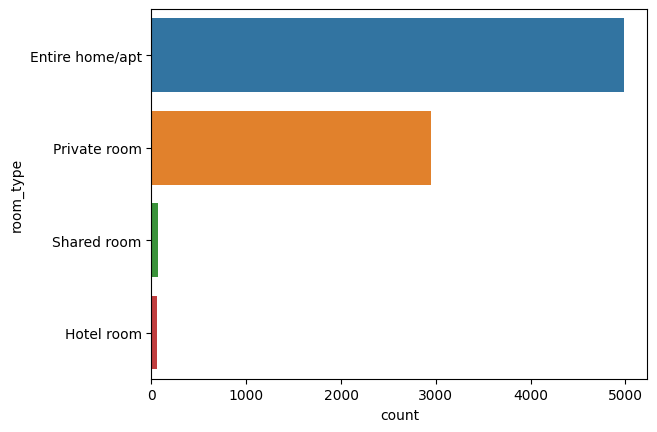

In [21]:
sns.countplot(df2, y=df2['room_type'], order=df2['room_type'].value_counts().index)

### price vs. availability

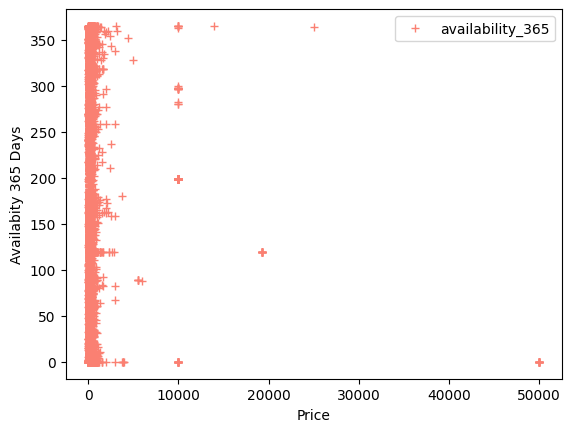

In [22]:
df2.plot(x='price', y='availability_365', style='+', color='salmon')
plt.xlabel('Price')
plt.ylabel('Availabity 365 Days')
plt.show()

### density plot for all the features

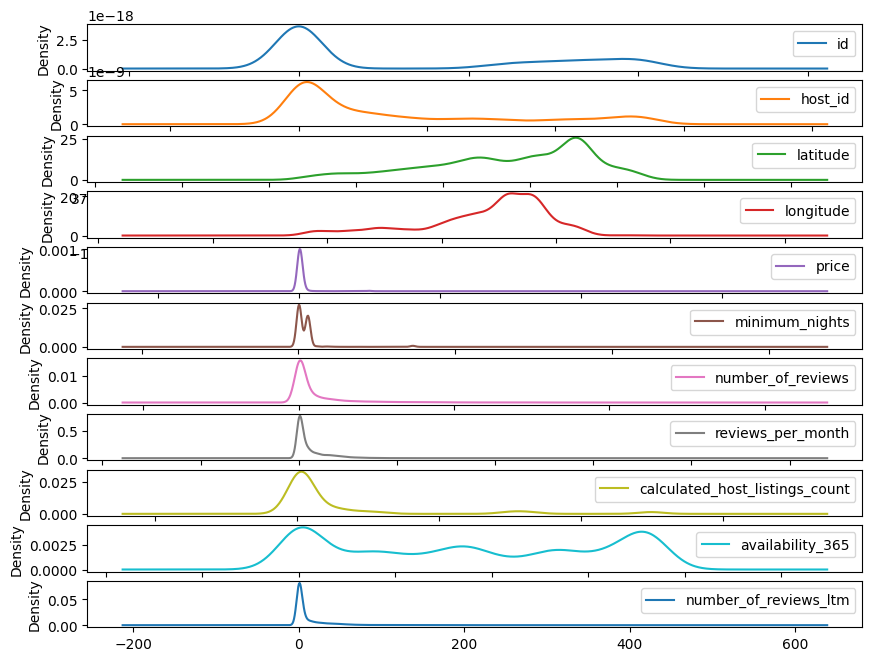

In [23]:
df2.plot(kind='density', subplots=True, layout=(14,1), sharex=False, figsize=(10,10))
plt.show()

### boxplot

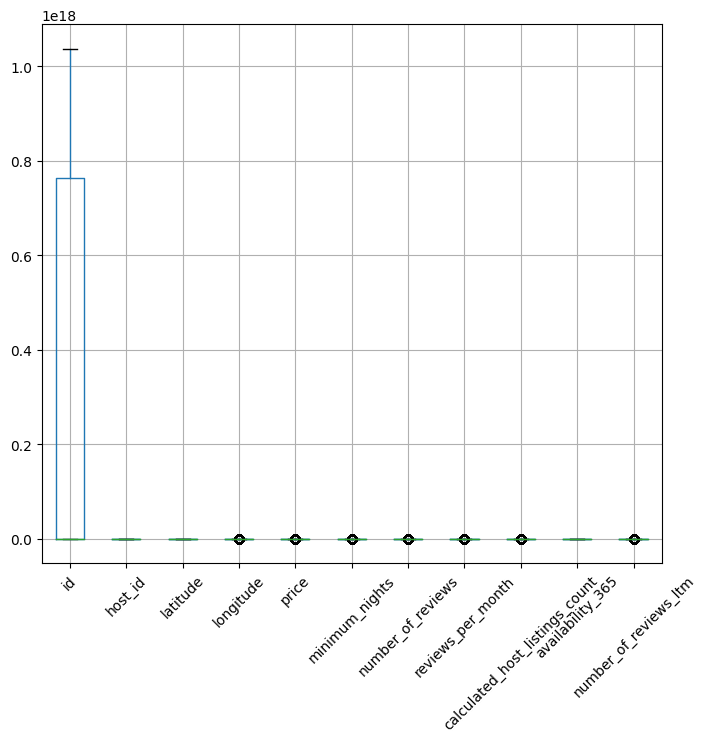

In [24]:
boxplot = df2.boxplot(figsize=(8,7),rot=45)

### scatterplot

Text(0.5, 1.0, 'Price according to availability')

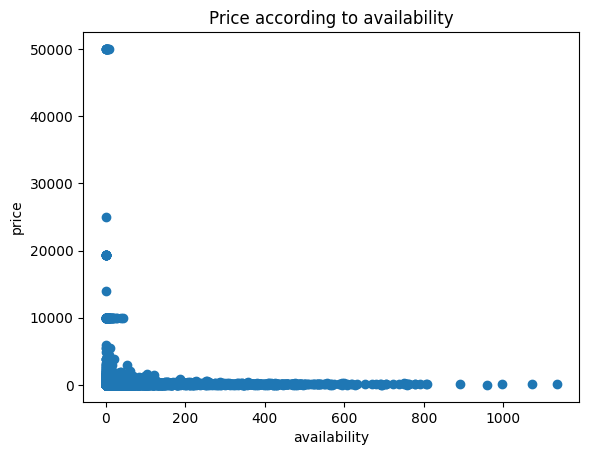

In [25]:
plt.scatter(df2['number_of_reviews'], df2['price'])
plt.xlabel("number_of_reviews")
plt.ylabel("price")
plt.title("Price according to number_of_reviews")

Text(0.5, 1.0, 'Price according to latitude')

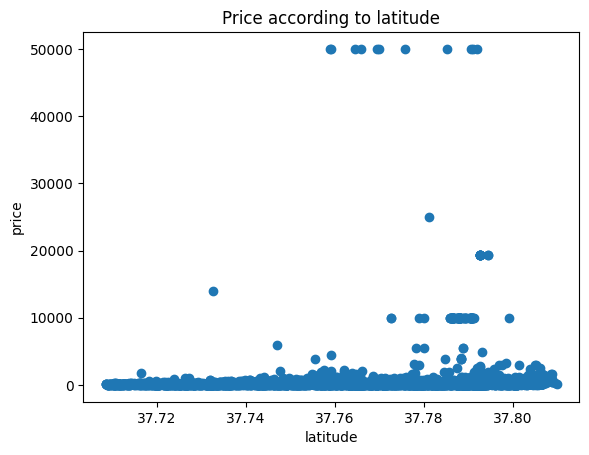

In [26]:
plt.scatter(df2['latitude'], df2['price'])
plt.xlabel("latitude")
plt.ylabel("price")
plt.title("Price according to latitude")

Text(0.5, 1.0, 'Price according to longitude')

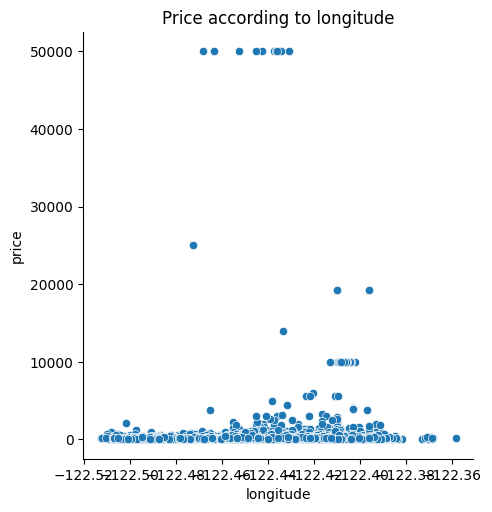

In [27]:
sns.relplot(x="longitude", y="price", data=df2)
plt.xlabel("longitude")
plt.ylabel("price")
plt.title("Price according to longitude")

Text(0.5, 1.0, 'Price according to minimum_nights')

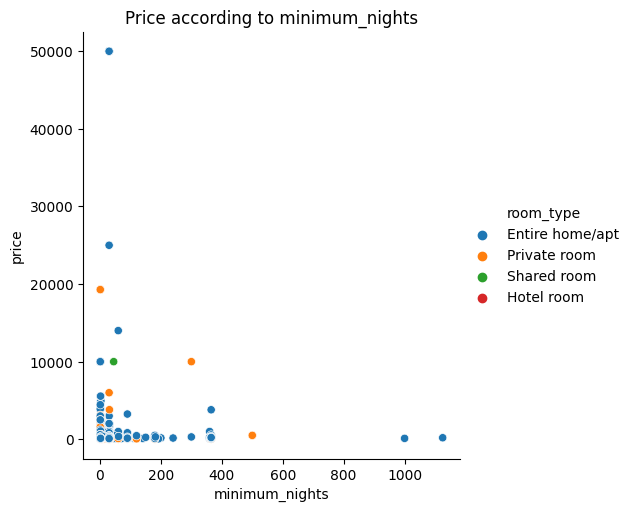

In [28]:
sns.relplot(x="minimum_nights", y="price", hue='room_type', data=df2)
plt.xlabel("minimum_nights")
plt.ylabel("price")
plt.title("Price according to minimum_nights")

### corelation map

<ipython-input-29-6c09a4bebf69>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df2.corr()


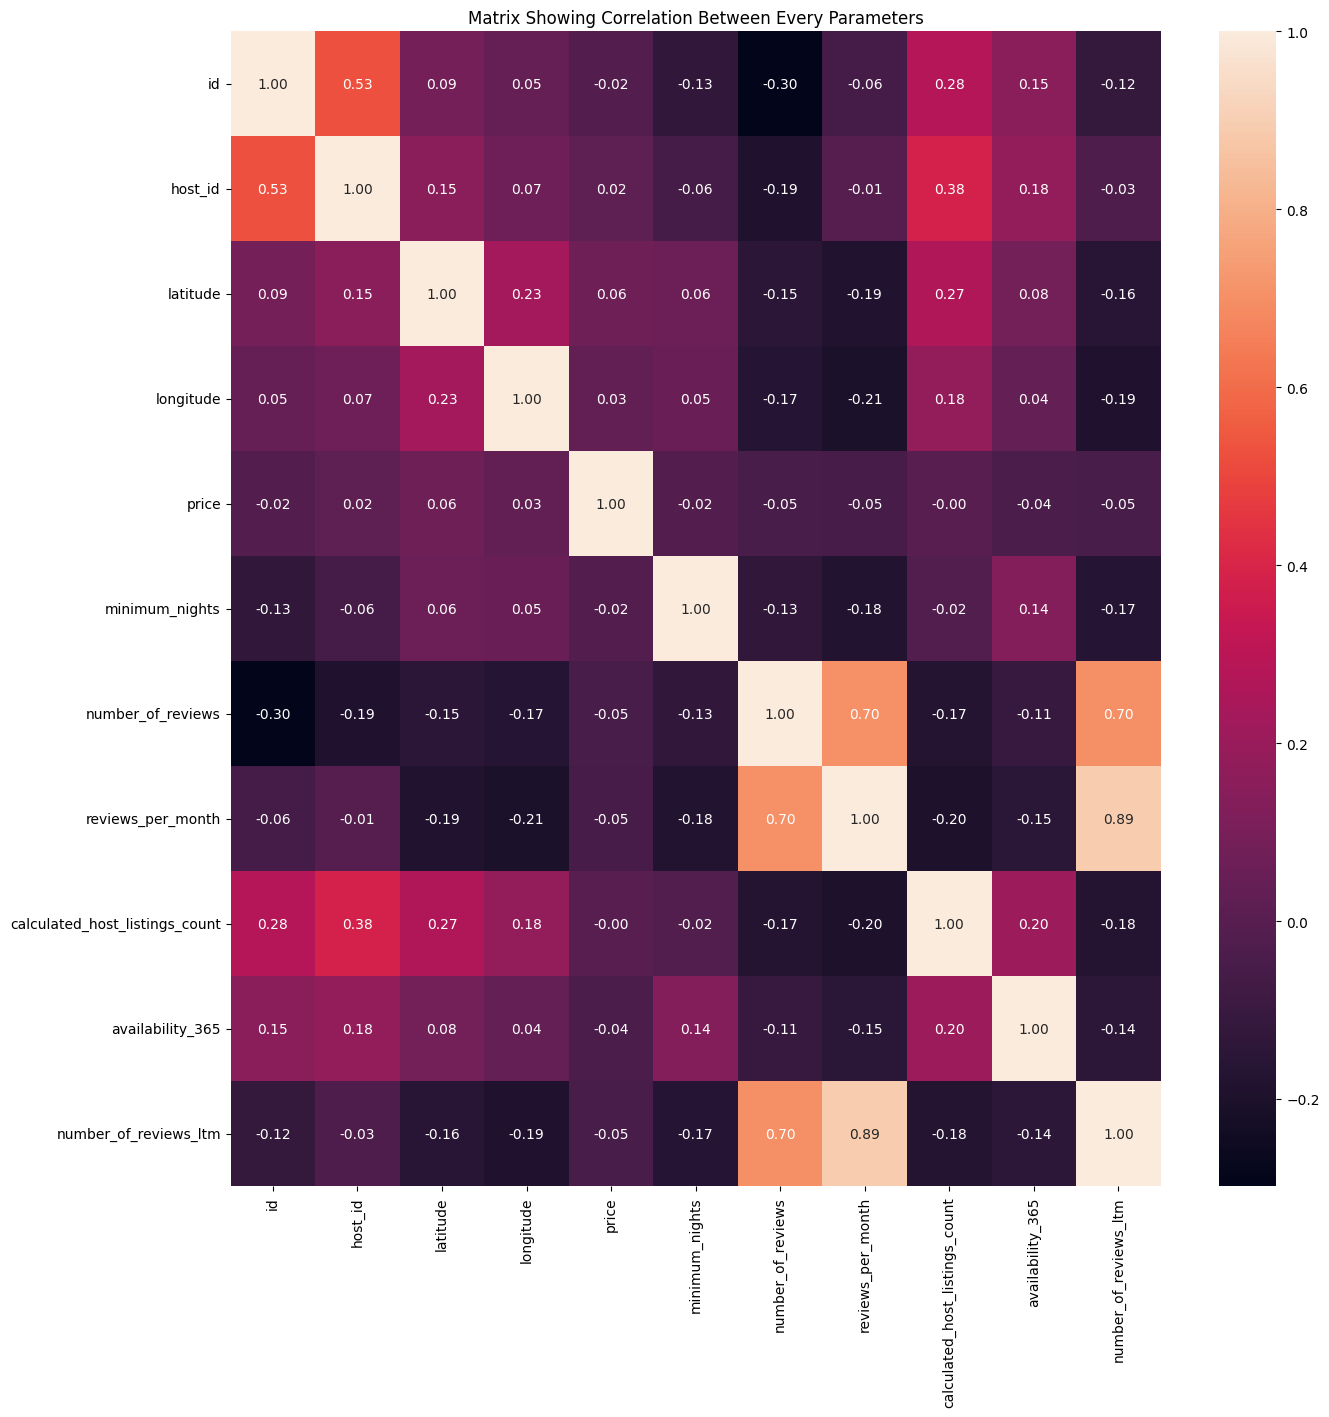

In [29]:
# heatmap of correlation between each parameter
plt.figure(figsize=(15,15))
ax = plt.axes()
corr = df2.corr()
sns.heatmap(corr, fmt='.2f', annot=True)
ax.set_title('Matrix Showing Correlation Between Every Parameters')
plt.show()

In [30]:
# correlation between numeric valus
df2.corr().style.background_gradient()

<ipython-input-30-bbe158268861>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corr().style.background_gradient()


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
id,1.000000,0.527223,0.088291,0.045728,-0.018657,-0.126335,-0.298209,-0.061923,0.275285,0.148132,-0.117730
host_id,0.527223,1.000000,0.148581,0.068713,0.017839,-0.064593,-0.190324,-0.005091,0.382382,0.178568,-0.034408
latitude,0.088291,0.148581,1.000000,0.234246,0.064520,0.059398,-0.146819,-0.185484,0.267415,0.083262,-0.159879
longitude,0.045728,0.068713,0.234246,1.000000,0.026735,0.053799,-0.169459,-0.206770,0.178578,0.040634,-0.188293
price,-0.018657,0.017839,0.064520,0.026735,1.000000,-0.017007,-0.045045,-0.052207,-0.000118,-0.043299,-0.046302
minimum_nights,-0.126335,-0.064593,0.059398,0.053799,-0.017007,1.000000,-0.130518,-0.179851,-0.021932,0.135550,-0.167415
number_of_reviews,-0.298209,-0.190324,-0.146819,-0.169459,-0.045045,-0.130518,1.000000,0.703597,-0.174356,-0.110225,0.700063
reviews_per_month,-0.061923,-0.005091,-0.185484,-0.206770,-0.052207,-0.179851,0.703597,1.000000,-0.198389,-0.154880,0.890342
calculated_host_listings_count,0.275285,0.382382,0.267415,0.178578,-0.000118,-0.021932,-0.174356,-0.198389,1.000000,0.204393,-0.175058
availability_365,0.148132,0.178568,0.083262,0.040634,-0.043299,0.135550,-0.110225,-0.154880,0.204393,1.000000,-0.142933


From the above both corelation maps, it is seen that there is no strong corelation between price and any one of the feature.

### numerical features distribution

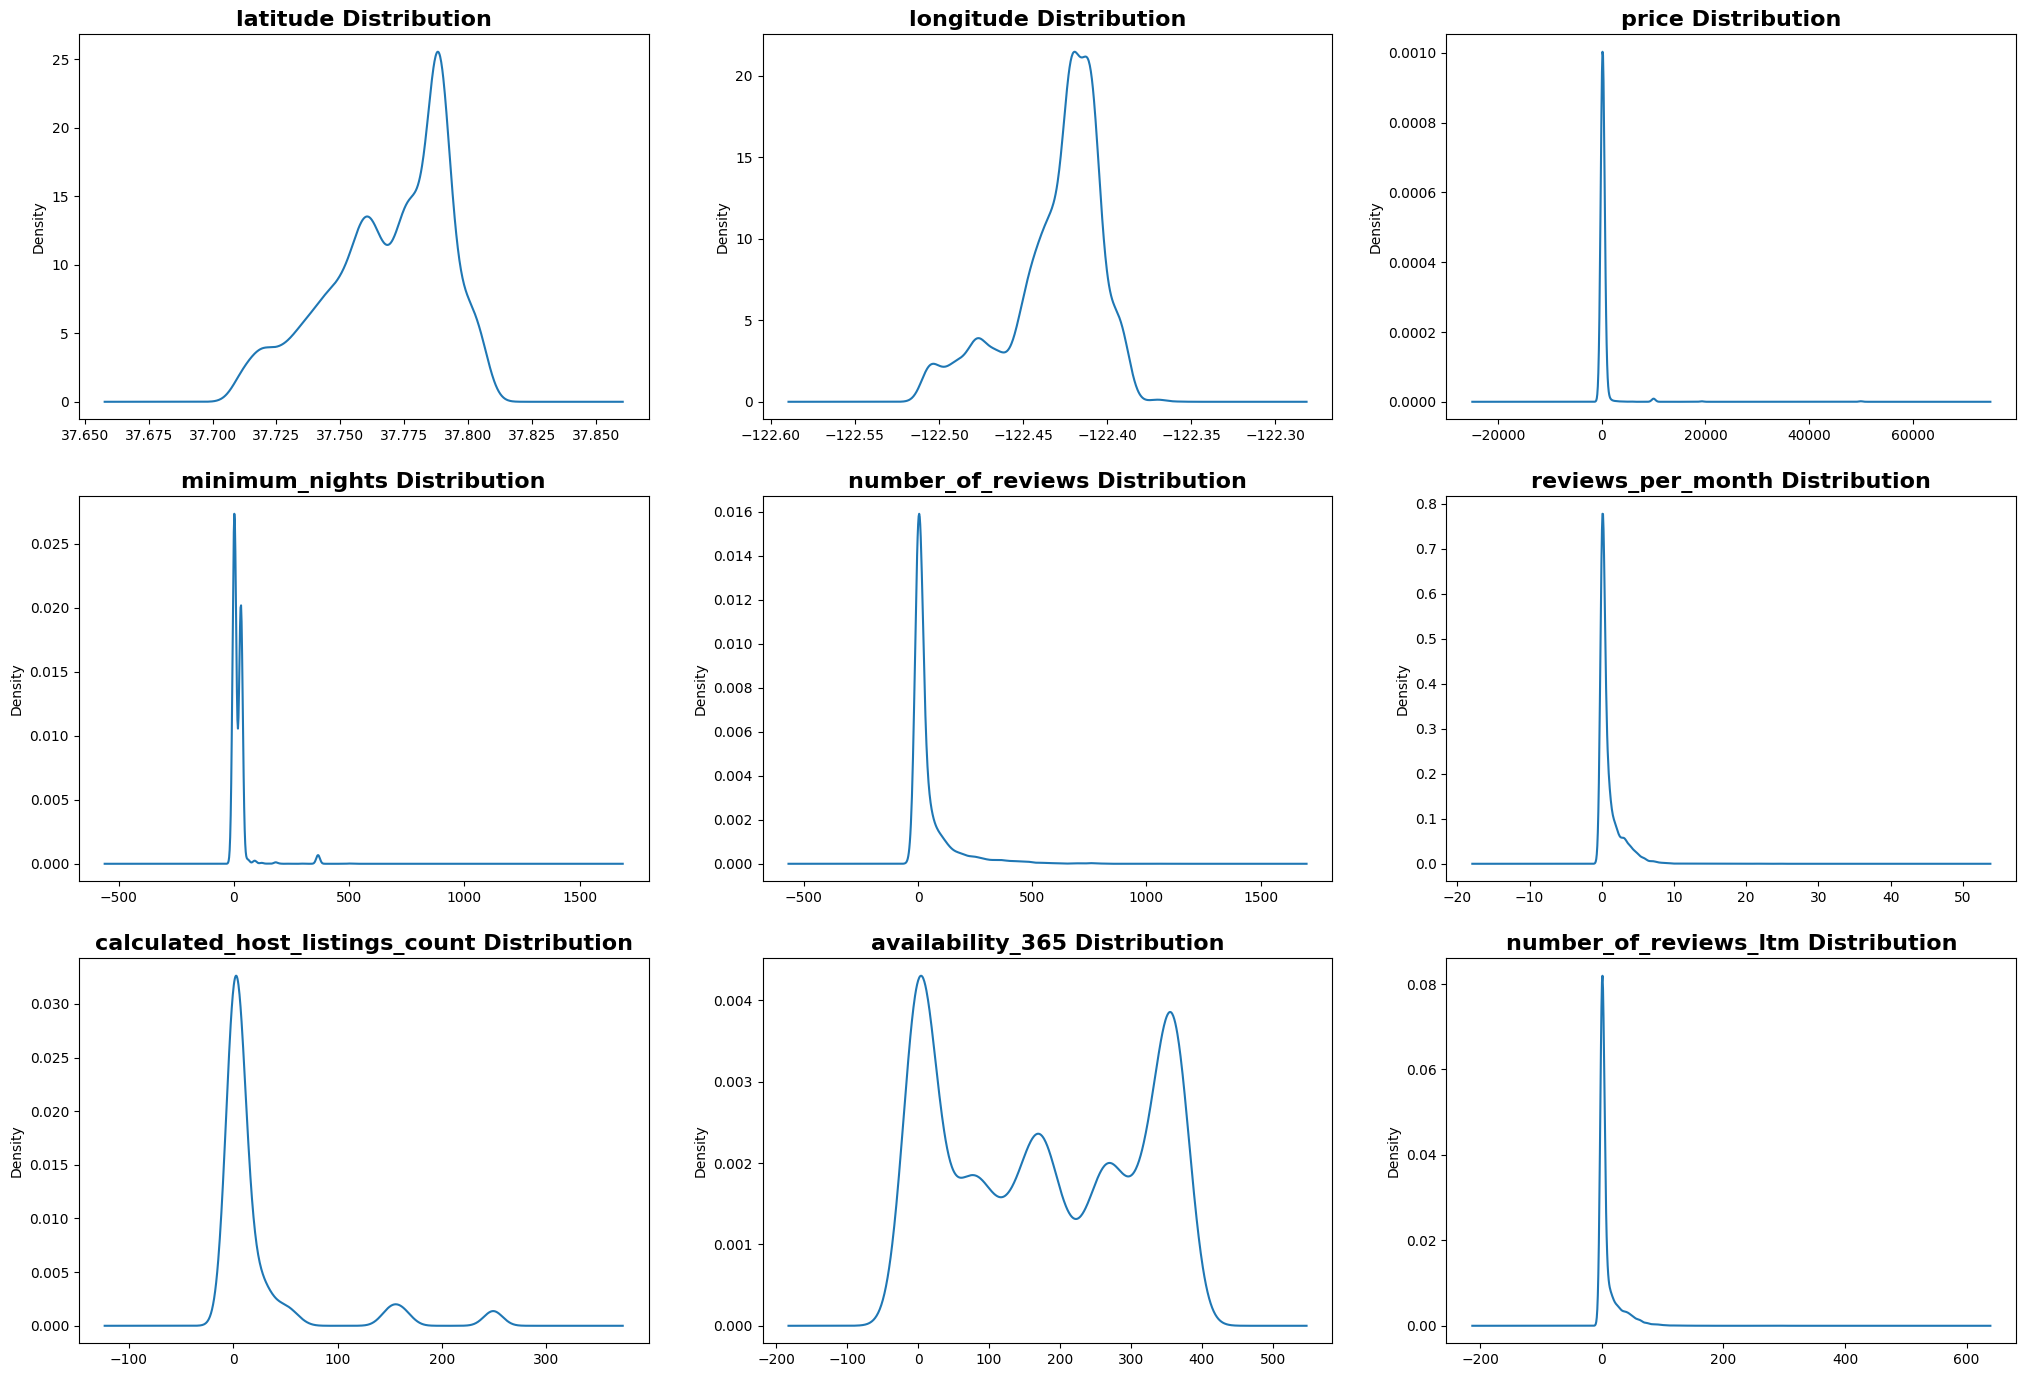

In [31]:
# numerical features distribution
fig, axes = plt.subplots(nrows=3, ncols=3)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        df2[numeric_features[aux]].plot(kind = 'kde', ax = col)
        col.set_title(numeric_features[aux] + ' Distribution', fontsize=16, fontweight='bold')
        aux += 1

### removing outliers

In [32]:
# removing outliers using inter-quantile range
lower_bound = .25
upper_bound = .75
iqr = df2[df2['price'].between(df2['price'].quantile(lower_bound), df2['price'].quantile(upper_bound), inclusive=True)]
iqr = iqr[iqr['number_of_reviews'] > 0]
iqr = iqr[iqr['calculated_host_listings_count'] < 10]
iqr = iqr[iqr['number_of_reviews'] < 200]
iqr = iqr[iqr['minimum_nights'] < 10]
iqr = iqr[iqr['reviews_per_month'] < 5]

<ipython-input-32-7398a8d806c1>:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  iqr = df2[df2['price'].between(df2['price'].quantile(lower_bound), df2['price'].quantile(upper_bound), inclusive=True)]


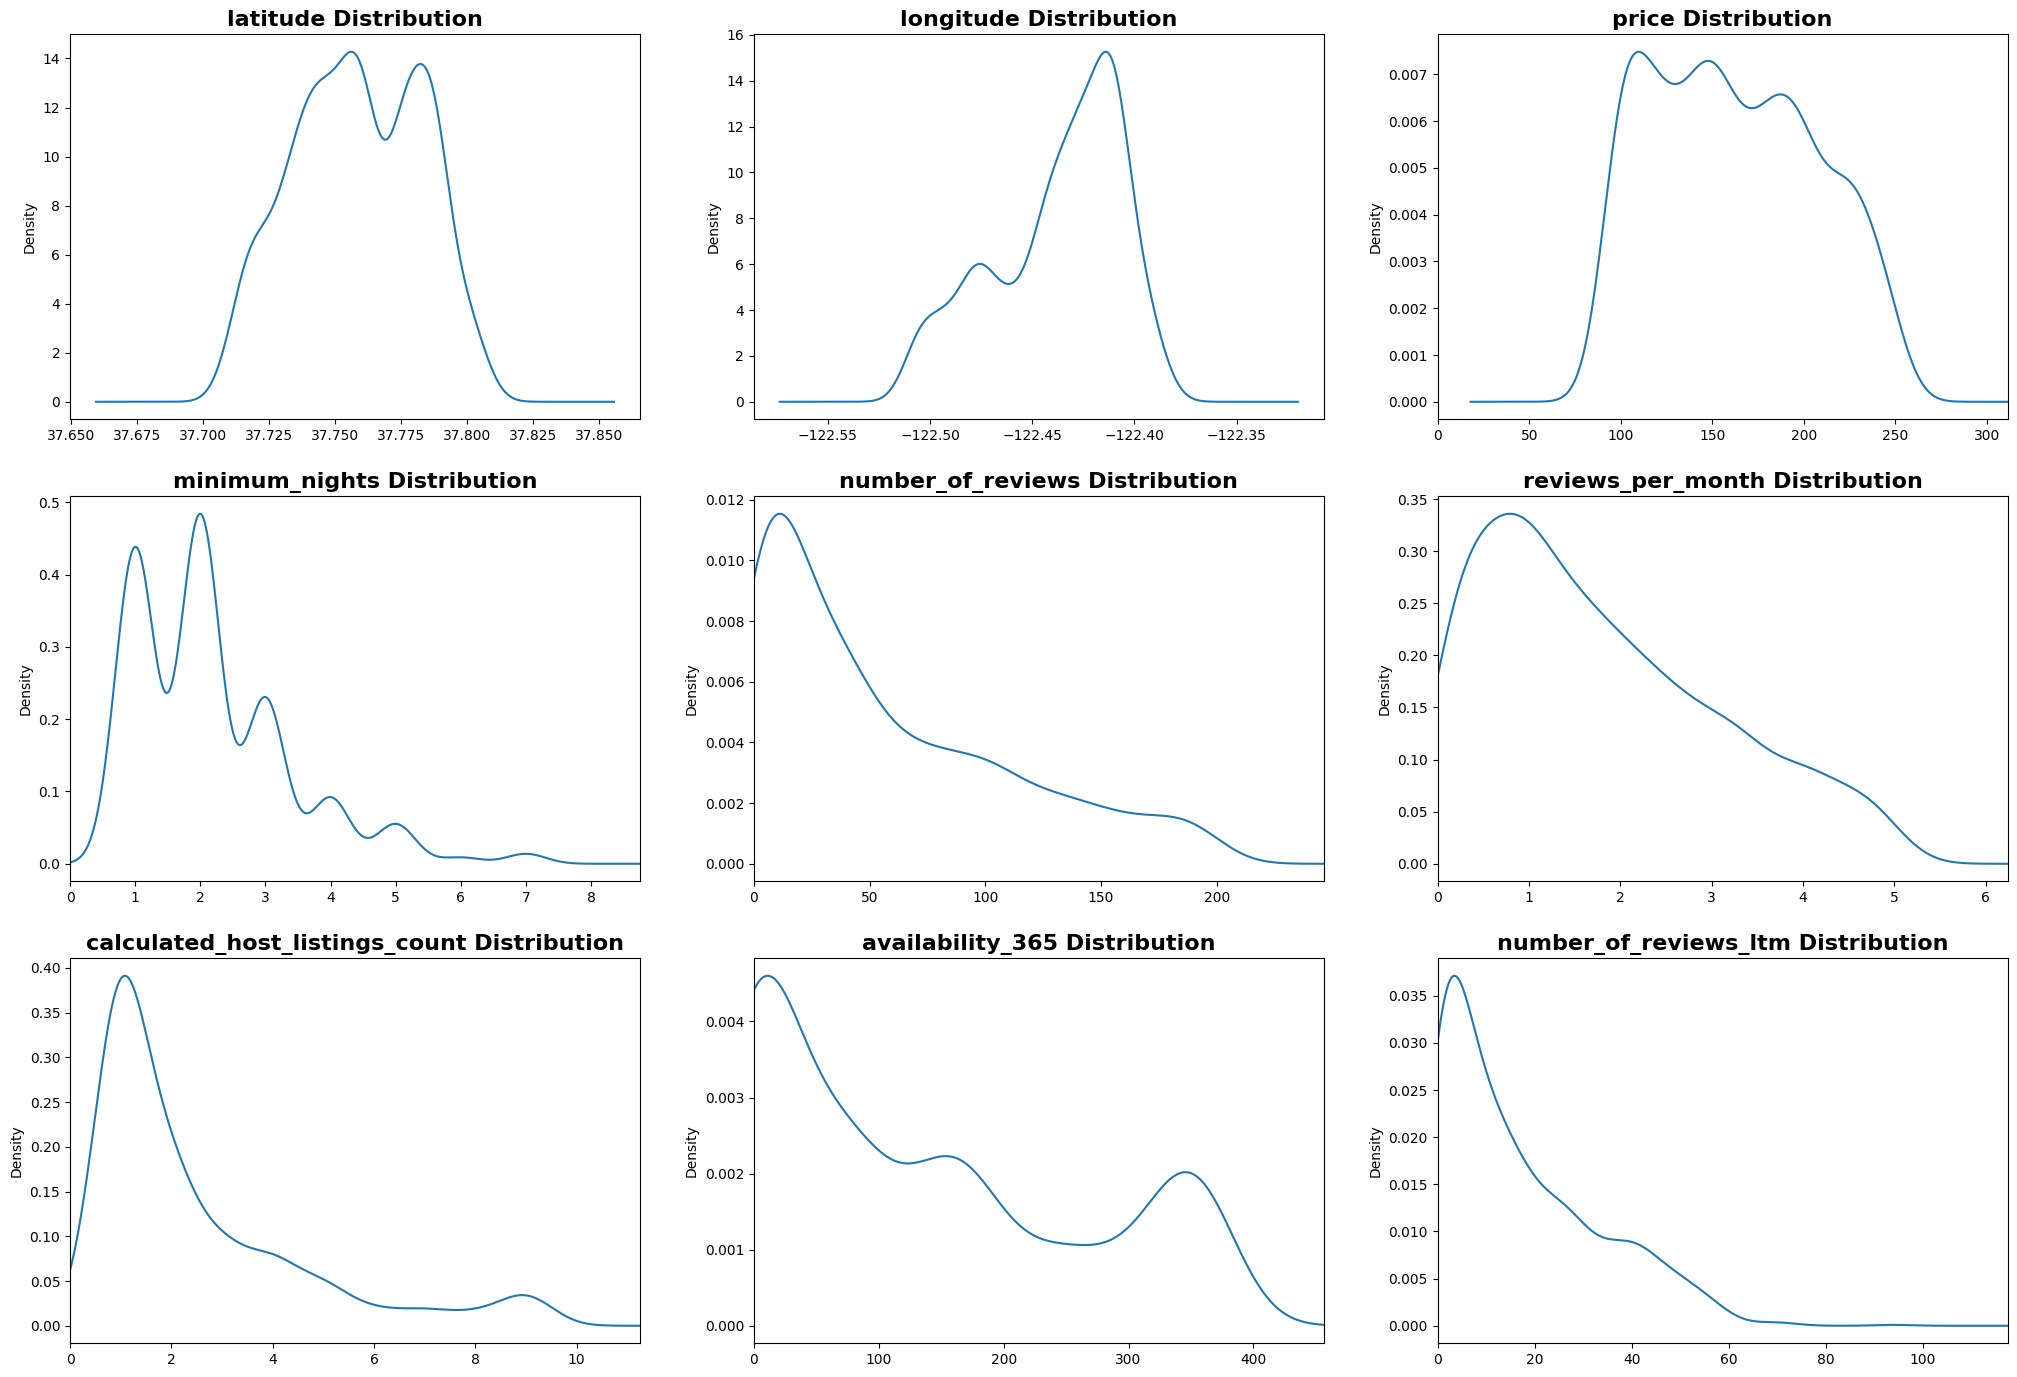

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=3)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        iqr[numeric_features[aux]].plot(kind = 'kde', ax = col)
        if numeric_features[aux] not in ['latitude','longitude']:
            col.set_xlim(0, iqr[numeric_features[aux]].max() + iqr[numeric_features[aux]].max() * 0.25)
        col.set_title(numeric_features[aux] + ' Distribution', fontsize=16, fontweight='bold')
        aux += 1

After removing outliers, it is seen that *number_of_reveiws*, *review_per_month*, _calculated_host_listings_count_ and *number_of_reviews_ltm* features are following exponential distribution where as other features follow multimodal distribution

### dataset distribution after outlier removal

In [34]:
per_df = iqr.copy()
desc = per_df.describe()

desc.loc['skew'] = desc.skew()
desc.loc['skew'] = desc.kurt()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

desc.drop(columns=['id','host_id']).style.highlight_max(axis=1)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,37.758582,-122.437467,162.140417,2.184061,55.346300,1.779839,2.496205,131.012334,16.726755
std,0.023921,0.031276,44.265786,1.221947,53.677545,1.299224,2.138483,126.581906,15.940098
min,37.708548,-122.510161,95.000000,1.000000,1.000000,0.020000,1.000000,0.000000,0.000000
25%,37.740415,-122.459575,124.000000,1.000000,10.000000,0.740000,1.000000,5.000000,3.000000
50%,37.758470,-122.430000,157.000000,2.000000,37.500000,1.495000,2.000000,89.000000,12.000000
75%,37.778993,-122.411569,199.000000,3.000000,91.000000,2.657500,3.000000,232.500000,27.000000
max,37.806587,-122.383400,249.000000,7.000000,197.000000,4.990000,9.000000,365.000000,94.000000
skew,8.945911,8.500171,7.606730,8.999291,8.171568,8.999572,8.998794,5.871645,8.820579


In [35]:
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.6, 0.5],
    specs=[[{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
           [            None                    , {"type": "bar"}]])

fig.add_trace(
    go.Bar(y=per_df.room_type.value_counts(),x=per_df.room_type.value_counts().index,name='Room Type'),
    row=1, col=2
)
fig.add_trace(
    go.Bar(y=per_df.minimum_nights.value_counts(),x=per_df.minimum_nights.value_counts().index,name='Minimum Nights'),
    row=2, col=2
)

fig.add_trace(

    go.Scattergeo(lat=per_df["latitude"],
                  lon=per_df["longitude"],
                  mode="markers",
                  text=per_df.price,
                  hoverinfo="text",
                  showlegend=True,
                  name='Price'
                  ,
                  marker=dict(color="crimson", size=4, opacity=0.8)),
    row=1, col=1
)

fig.update_geos(
    projection_type="orthographic",
    landcolor="white",
    oceancolor="MidnightBlue",
    showocean=True,
    lakecolor="LightBlue",
    projection_rotation_lon=-92,
    projection_rotation_lat=15

)

fig.update_xaxes(tickangle=45)

fig.update_layout(title='Distribution Of Different Room Types')
fig.show()

### wordcloud

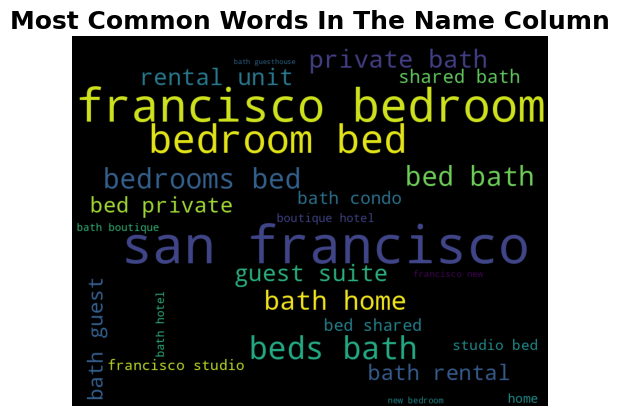

In [36]:
stopwords=list(STOPWORDS)

names = ' '.join(per_df['name'].str.lower().values)
plt.imshow(WordCloud(width = 900, height = 700, min_font_size = 13, stopwords = stopwords).generate(names))
plt.title('Most Common Words In The Name Column', fontsize = 18, fontweight = 'bold')
plt.axis('off')


names = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", names)
names = re.findall(r'\w+', names)
names = ' '.join([tok for tok in names if tok not in stopwords and len(tok) >2])

names_freq_dic = nltk.FreqDist(names.split(' '))
dict(names_freq_dic)

plt.show()

From the above wordcloud of names, it can be understood that this column describes the room facitlity itself. The words that contribute to the price of the room.

## Data Preprocessing And Feature Extraction

In [37]:
per_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054 entries, 2 to 7986
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1054 non-null   int64  
 1   name                            1054 non-null   object 
 2   host_id                         1054 non-null   int64  
 3   host_name                       1054 non-null   object 
 4   neighbourhood                   1054 non-null   object 
 5   latitude                        1054 non-null   float64
 6   longitude                       1054 non-null   float64
 7   room_type                       1054 non-null   object 
 8   price                           1054 non-null   int64  
 9   minimum_nights                  1054 non-null   int64  
 10  number_of_reviews               1054 non-null   int64  
 11  last_review                     1054 non-null   object 
 12  reviews_per_month               10

### conversion of text and categorical data

In [38]:
# on outlier removed dataset
le = LabelEncoder()
per_df['neighbourhood_cat'] = le.fit_transform(per_df['neighbourhood'])
per_df['room_type_cat'] = le.fit_transform(per_df['room_type'])
per_df['license_cat'] = le.fit_transform(per_df['license'])

In [39]:
# on the dataset with outliers
df2['neighbourhood_cat1'] = le.fit_transform(df2['neighbourhood'])
df2['room_type_cat1'] = le.fit_transform(df2['room_type'])
df2['license_cat1'] = le.fit_transform(df2['license'])

### corelation map after encoding

In [40]:
# for outlier removed dataset
per_df.corr().style.background_gradient()

<ipython-input-40-7aefa20e0d7c>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_cat,room_type_cat,license_cat
id,1.000000,0.305859,-0.002022,-0.097206,0.032530,-0.095448,-0.539353,0.168495,0.011424,0.015202,-0.092863,0.018368,-0.150145,-0.263657
host_id,0.305859,1.000000,0.074354,-0.008812,-0.055596,-0.182107,-0.228457,0.117315,0.241258,0.049719,-0.000655,-0.029239,-0.017838,-0.120704
latitude,-0.002022,0.074354,1.000000,0.099021,0.109924,-0.011584,-0.097426,-0.161479,0.368642,-0.002926,-0.154146,0.123185,0.299808,-0.055878
longitude,-0.097206,-0.008812,0.099021,1.000000,-0.076344,0.017686,-0.152818,-0.254112,0.269355,-0.002886,-0.221487,-0.278702,0.182526,-0.013257
price,0.032530,-0.055596,0.109924,-0.076344,1.000000,0.088132,-0.140361,-0.101887,-0.139964,-0.042853,-0.103274,-0.003888,-0.334040,-0.015491
minimum_nights,-0.095448,-0.182107,-0.011584,0.017686,0.088132,1.000000,0.042622,-0.165858,-0.152007,-0.070885,-0.118428,0.058930,-0.190228,0.114014
number_of_reviews,-0.539353,-0.228457,-0.097426,-0.152818,-0.140361,0.042622,1.000000,0.408827,-0.252491,0.002020,0.531220,0.046338,-0.033538,0.264942
reviews_per_month,0.168495,0.117315,-0.161479,-0.254112,-0.101887,-0.165858,0.408827,1.000000,-0.267343,-0.011814,0.800324,0.080889,-0.252255,0.030041
calculated_host_listings_count,0.011424,0.241258,0.368642,0.269355,-0.139964,-0.152007,-0.252491,-0.267343,1.000000,0.172641,-0.245669,0.027268,0.428854,-0.076493
availability_365,0.015202,0.049719,-0.002926,-0.002886,-0.042853,-0.070885,0.002020,-0.011814,0.172641,1.000000,-0.022225,0.049886,0.119401,0.031854


In [41]:
# for the dataset with outliers

df2.corr().style.background_gradient()

<ipython-input-41-de8f20e6a8ea>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_cat1,room_type_cat1,license_cat1
id,1.000000,0.527223,0.088291,0.045728,-0.018657,-0.126335,-0.298209,-0.061923,0.275285,0.148132,-0.117730,0.052008,0.070804,-0.145804
host_id,0.527223,1.000000,0.148581,0.068713,0.017839,-0.064593,-0.190324,-0.005091,0.382382,0.178568,-0.034408,0.028839,0.229526,-0.098770
latitude,0.088291,0.148581,1.000000,0.234246,0.064520,0.059398,-0.146819,-0.185484,0.267415,0.083262,-0.159879,0.122822,0.046160,-0.095888
longitude,0.045728,0.068713,0.234246,1.000000,0.026735,0.053799,-0.169459,-0.206770,0.178578,0.040634,-0.188293,-0.169306,0.023027,-0.080815
price,-0.018657,0.017839,0.064520,0.026735,1.000000,-0.017007,-0.045045,-0.052207,-0.000118,-0.043299,-0.046302,-0.039183,-0.006443,-0.036390
minimum_nights,-0.126335,-0.064593,0.059398,0.053799,-0.017007,1.000000,-0.130518,-0.179851,-0.021932,0.135550,-0.167415,0.051411,-0.005486,0.020917
number_of_reviews,-0.298209,-0.190324,-0.146819,-0.169459,-0.045045,-0.130518,1.000000,0.703597,-0.174356,-0.110225,0.700063,0.007611,0.023349,0.186839
reviews_per_month,-0.061923,-0.005091,-0.185484,-0.206770,-0.052207,-0.179851,0.703597,1.000000,-0.198389,-0.154880,0.890342,0.024376,0.007919,0.081915
calculated_host_listings_count,0.275285,0.382382,0.267415,0.178578,-0.000118,-0.021932,-0.174356,-0.198389,1.000000,0.204393,-0.175058,0.038418,0.187776,-0.032867
availability_365,0.148132,0.178568,0.083262,0.040634,-0.043299,0.135550,-0.110225,-0.154880,0.204393,1.000000,-0.142933,0.072082,0.056261,-0.005158


## Linear Regression Model Training

In [42]:
# create new dataframe with only required columns with removal of outliers
df3 = per_df[[ 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'room_type_cat', 'availability_365', 'number_of_reviews_ltm', 'neighbourhood_cat', 'license_cat']]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054 entries, 2 to 7986
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        1054 non-null   float64
 1   longitude                       1054 non-null   float64
 2   price                           1054 non-null   int64  
 3   minimum_nights                  1054 non-null   int64  
 4   number_of_reviews               1054 non-null   int64  
 5   reviews_per_month               1054 non-null   float64
 6   calculated_host_listings_count  1054 non-null   int64  
 7   room_type_cat                   1054 non-null   int64  
 8   availability_365                1054 non-null   int64  
 9   number_of_reviews_ltm           1054 non-null   int64  
 10  neighbourhood_cat               1054 non-null   int64  
 11  license_cat                     1054 non-null   int64  
dtypes: float64(3), int64(9)
memory usa

In [43]:
# create new dataframe with only required columns with outliers

df4 = df2[[ 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'room_type_cat1', 'availability_365', 'number_of_reviews_ltm', 'neighbourhood_cat1', 'license_cat1']]
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8056 entries, 0 to 8055
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        8056 non-null   float64
 1   longitude                       8056 non-null   float64
 2   price                           8056 non-null   int64  
 3   minimum_nights                  8056 non-null   int64  
 4   number_of_reviews               8056 non-null   int64  
 5   reviews_per_month               8056 non-null   float64
 6   calculated_host_listings_count  8056 non-null   int64  
 7   room_type_cat1                  8056 non-null   int64  
 8   availability_365                8056 non-null   int64  
 9   number_of_reviews_ltm           8056 non-null   int64  
 10  neighbourhood_cat1              8056 non-null   int64  
 11  license_cat1                    8056 non-null   int64  
dtypes: float64(3), int64(9)
memory usa

### finding important features using ensemble learning

feature: latitude, importance: 0.034927837550640106
feature: longitude, importance: 0.029905900359153748
feature: price, importance: 0.031082065775990486
feature: minimum_nights, importance: 0.033468011766672134
feature: number_of_reviews, importance: 0.0404425710439682
feature: reviews_per_month, importance: 0.07390802353620529
feature: calculated_host_listings_count, importance: 0.5855191349983215
feature: room_type_cat, importance: 0.03219135105609894
feature: availability_365, importance: 0.05058884993195534
feature: number_of_reviews_ltm, importance: 0.04619423300027847
feature: neighbourhood_cat, importance: 0.04177207127213478


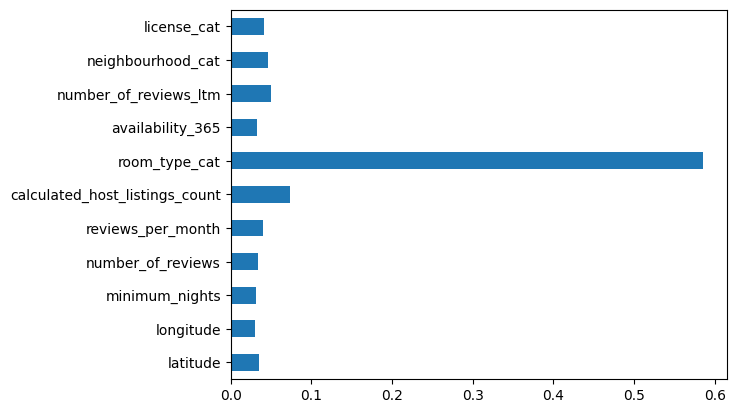

In [44]:
# feature importance without outliers

X_ = df3.drop('price',axis=1)
Y = df3['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_, Y, test_size=0.2, random_state=0)

xg_reg = XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train1,y_train1)

for feat, importance in zip(df3.columns, xg_reg.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

# plot the features
(pd.Series(xg_reg.feature_importances_, index=X_.columns).plot(kind='barh'))

preds = xg_reg.predict(X_test1)

feature: latitude, importance: 0.022402267903089523
feature: longitude, importance: 0.018197549507021904
feature: price, importance: 0.011100778356194496
feature: minimum_nights, importance: 0.002796564484015107
feature: number_of_reviews, importance: 0.006315060891211033
feature: reviews_per_month, importance: 0.4763340651988983
feature: calculated_host_listings_count, importance: 0.09820779412984848
feature: room_type_cat, importance: 0.33098307251930237
feature: availability_365, importance: 0.001725026173517108
feature: number_of_reviews_ltm, importance: 0.02803715504705906
feature: neighbourhood_cat, importance: 0.0039006308652460575


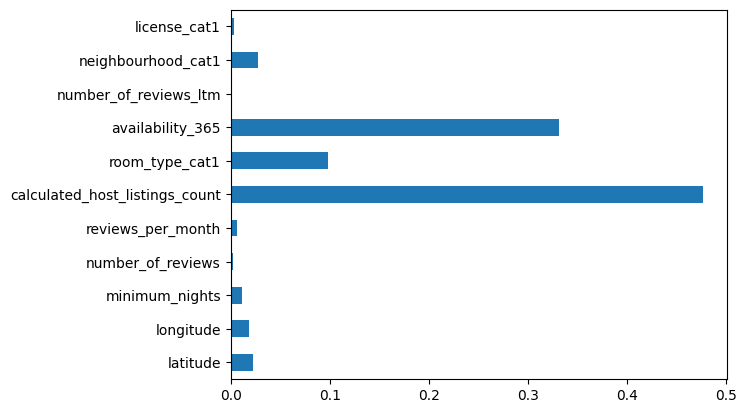

In [45]:
# feature importance with outliers

X_ = df4.drop('price',axis=1)
Y = df4['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_, Y, test_size=0.2, random_state=0)

xg_reg = XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train1, y_train1)

for feat, importance in zip(df3.columns, xg_reg.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

# plot the features
(pd.Series(xg_reg.feature_importances_, index=X_.columns).plot(kind='barh'))


preds = xg_reg.predict(X_test1)

From the above feature importance graph, it can be seen that the _room_type_ has the maximum relevance with the price. So, the regression model is built with _room_type_ as feature variable.

### training linear regression model

In [46]:
X = df3['room_type_cat'].values.reshape(-1, 1)
y = df3['price'].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(843, 1) (211, 1) (843, 1) (211, 1)


In [47]:
lr = LinearRegression()
lr.fit(x_train, y_train)

print('Intercept: ', lr.intercept_)
print('Coefficients: ', lr.coef_)


Intercept:  [173.38362654]
Coefficients:  [[-15.13524535]]


In [48]:
y_preds = lr.predict(x_test)

print(y_preds.flatten().shape)
print(y_test.shape)

lr_predictions = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_preds.flatten()})
lr_predictions

(211,)
(211, 1)


,Actual,Predicted
0,224,173.38363
1,138,173.38363
2,195,143.11314
3,95,143.11314
4,101,143.11314
...,...,...
206,118,143.11314
207,228,173.38363
208,180,173.38363
209,177,143.11314


### linear regression model evaluation

In [49]:
mae = metrics.mean_absolute_error(y_test, y_preds)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test, y_preds)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:35.1458466008717
Mean Square Error:1718.5582116187434
Root Mean Square Error:41.4554967600045


In [50]:
print(lr.score(x_test, y_test))

0.11226042728912833


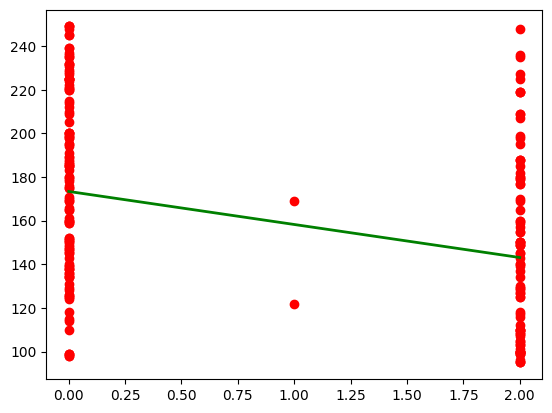

In [51]:
plt.scatter(x_test, y_test,  color='red')
plt.plot(x_test, y_preds, color='green', linewidth=2)
plt.show()

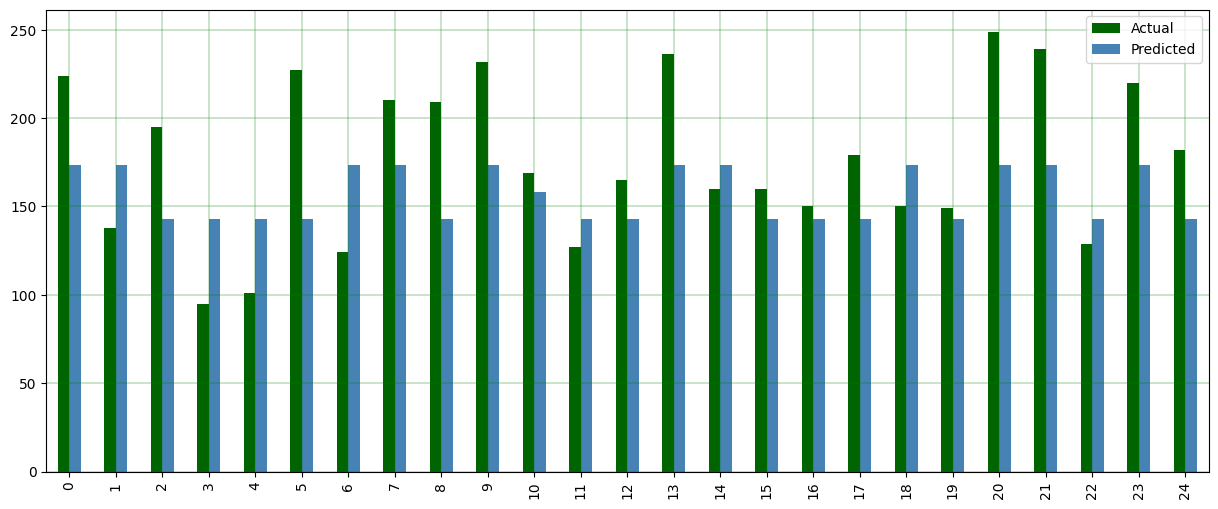

In [52]:
# comparison about actual and predicted values
first_25_preds = lr_predictions.head(25)
c = 'darkgreen', 'steelblue'
first_25_preds.plot(kind='bar',figsize=(15,6), color=c)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Training with Ridge Regressor

In [53]:
ridge = Ridge(alpha=0.5)
ridge.fit(x_train, y_train)

print('Intercept: ', ridge.intercept_)
print('Coefficients: ', ridge.coef_)

Intercept:  [173.37616458]
Coefficients:  [[-15.12572881]]


In [54]:
y_preds_ridge = ridge.predict(x_test)

print(y_preds_ridge.flatten().shape)
print(y_test.shape)

ridge_predictions = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_preds_ridge.flatten()})
ridge_predictions

(211,)
(211, 1)


,Actual,Predicted
0,224,173.37616
1,138,173.37616
2,195,143.12471
3,95,143.12471
4,101,143.12471
...,...,...
206,118,143.12471
207,228,173.37616
208,180,173.37616
209,177,143.12471


### ridge regression model evaluation

In [55]:
mae = metrics.mean_absolute_error(y_test, y_preds_ridge)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test, y_preds_ridge)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_preds_ridge))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:35.1462745626101
Mean Square Error:1718.5614051547755
Root Mean Square Error:41.455535277629394


In [56]:
print(ridge.score(x_test, y_test))

0.1122587776340318


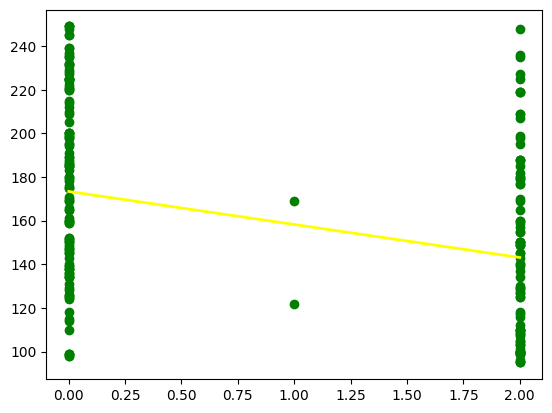

In [57]:
plt.scatter(x_test, y_test,  color='green')
plt.plot(x_test, y_preds_ridge, color='yellow', linewidth=2)
plt.show()

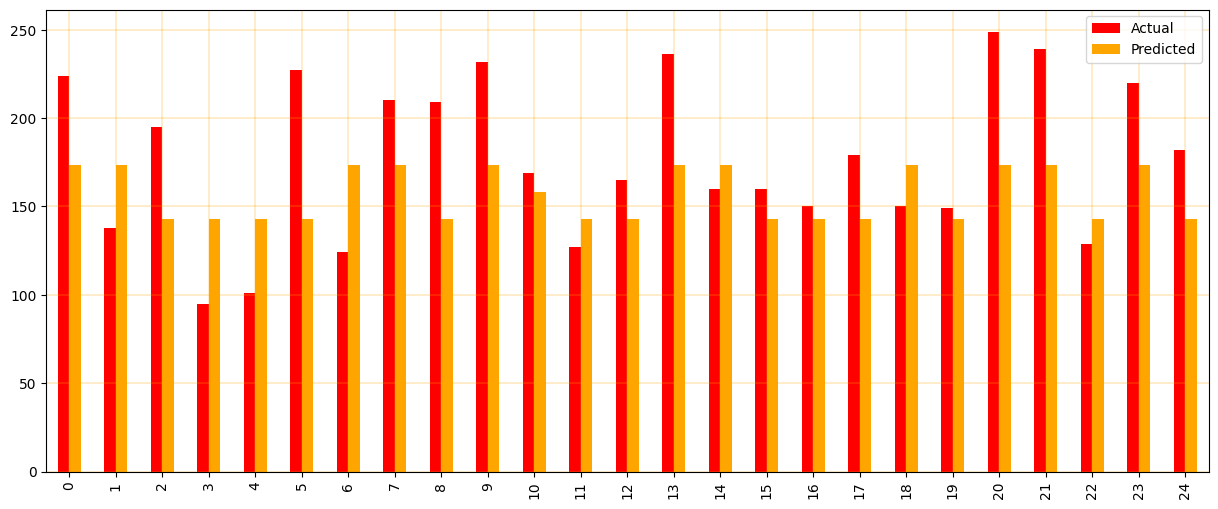

In [58]:
# comparison about actual and predicted values
first_25_preds = ridge_predictions.head(25)
c = 'red', 'orange'
first_25_preds.plot(kind='bar',figsize=(15,6), color=c)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='orange')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='red')
plt.show()

## Training with Lasso regressor

In [59]:
lasso = Lasso(alpha=0.5)
lasso.fit(x_train, y_train)

print('Intercept: ', lasso.intercept_)
print('Coefficients: ', lasso.coef_)

Intercept:  [172.96775]
Coefficients:  [-14.6048612]


In [60]:
y_preds_lasso = lasso.predict(x_test)

print(y_preds_lasso.flatten().shape)
print(y_test.shape)

lasso_predictions = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_preds_lasso.flatten()})
lasso_predictions

(211,)
(211, 1)


,Actual,Predicted
0,224,172.96775
1,138,172.96775
2,195,143.75803
3,95,143.75803
4,101,143.75803
...,...,...
206,118,143.75803
207,228,172.96775
208,180,172.96775
209,177,143.75803


### lasso regression model evaluation

In [61]:
mae = metrics.mean_absolute_error(y_test, y_preds_lasso)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test, y_preds_lasso)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_preds_lasso))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:35.16969812895892
Mean Square Error:1719.0040583667117
Root Mean Square Error:41.46087382541173


In [62]:
print(lasso.score(x_test, y_test))

0.11203012039649007


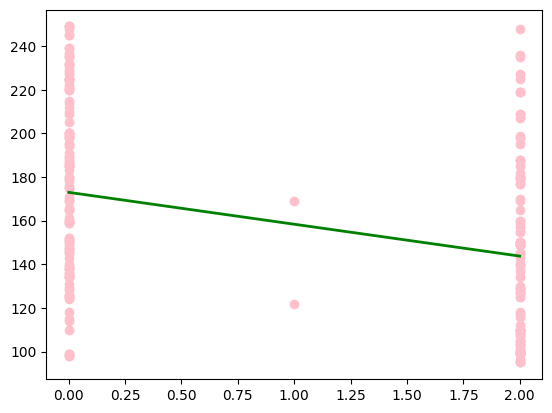

In [63]:
plt.scatter(x_test, y_test,  color='pink')
plt.plot(x_test, y_preds_lasso, color='green', linewidth=2)
plt.show()

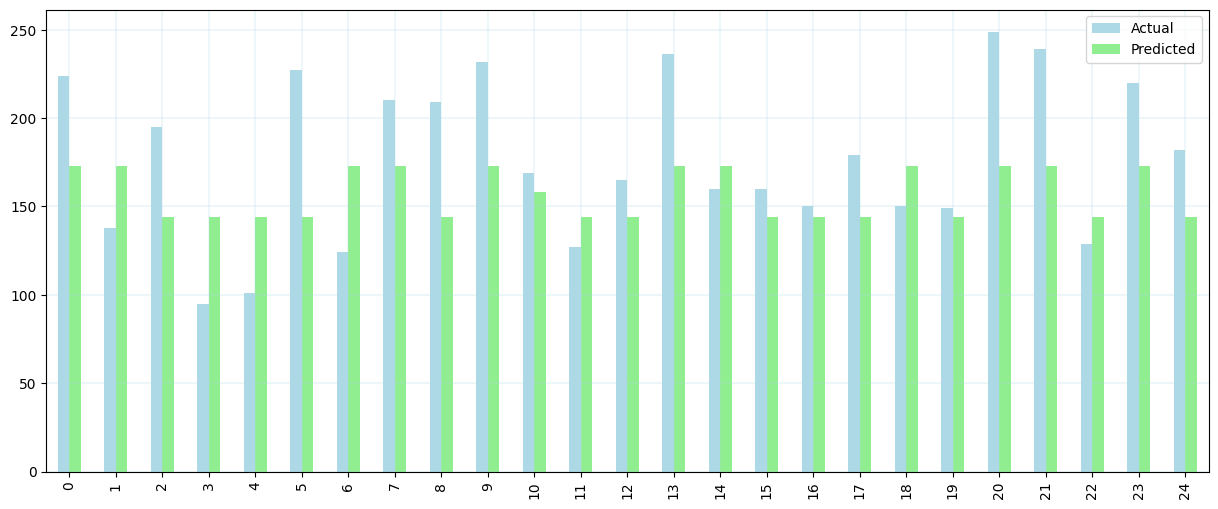

In [64]:
# comparison about actual and predicted values
first_25_preds = lasso_predictions.head(25)
c = 'lightblue', 'lightgreen'
first_25_preds.plot(kind='bar',figsize=(15,6), color=c)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='lightblue')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='yellow')
plt.show()

## Training with XGBoost Regressor

In [65]:
xgb = XGBRegressor(objective='reg:squarederror')

xgb.fit(x_train, y_train)

print('Intercept: ', lr.intercept_)
print('Coefficients: ', lr.coef_)

Intercept:  [173.38362654]
Coefficients:  [[-15.13524535]]


In [66]:
y_preds_xgb = xgb.predict(x_test)

print(y_preds_xgb.flatten().shape)
print(y_test.shape)

xgb_predictions = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_preds_xgb.flatten()})
xgb_predictions

(211,)
(211, 1)


,Actual,Predicted
0,224,173.36415
1,138,173.36415
2,195,143.08286
3,95,143.08286
4,101,143.08286
...,...,...
206,118,143.08286
207,228,173.36415
208,180,173.36415
209,177,143.08286


### XGBoost model evaluation

In [67]:
mae = metrics.mean_absolute_error(y_test, y_preds_xgb)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test, y_preds_xgb)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_preds_xgb))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:35.14639029118687
Mean Square Error:1719.3301335184876
Root Mean Square Error:41.46480596262917


In [68]:
print(xgb.score(x_test, y_test))

0.11186168279923425


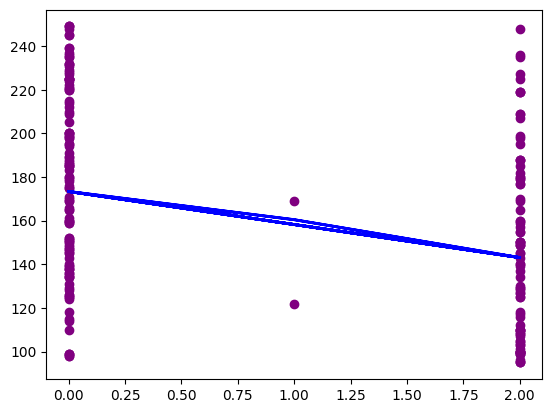

In [69]:
plt.scatter(x_test, y_test,  color='purple')
plt.plot(x_test, y_preds_xgb, color='blue', linewidth=2)
plt.show()

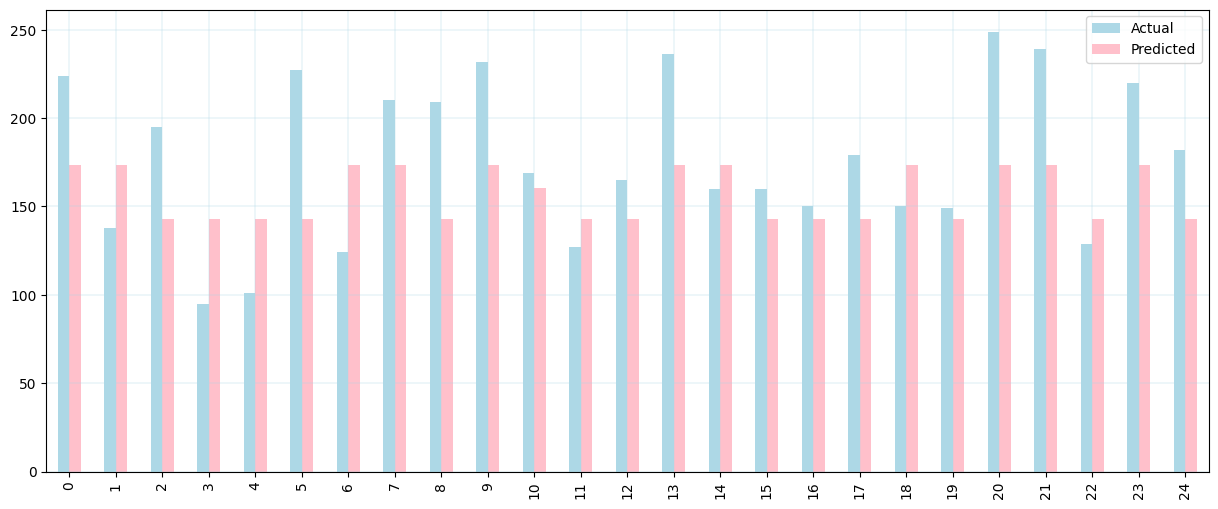

In [70]:
# comparison about actual and predicted values
first_25_preds = xgb_predictions.head(25)
c = 'lightblue', 'pink'
first_25_preds.plot(kind='bar',figsize=(15,6), color=c)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='lightblue')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='yellow')
plt.show()

## Training linear regressor with all features

In [82]:
X = df3.drop(['price'], axis=1)
y = df3['price'].values.reshape(-1, 1)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=35)
print(x_train_1.shape, x_test_1.shape, y_train_1.shape, y_test_1.shape)

(843, 11) (211, 11) (843, 1) (211, 1)


In [83]:
lr_all = LinearRegression()
lr_all.fit(x_train_1, y_train_1)

print('Intercept: ', lr_all.intercept_)
print('Coefficients: ', lr_all.coef_)


Intercept:  [-21184.87566099]
Coefficients:  [[ 4.76993134e+02 -2.75526649e+01 -1.35351240e+00 -6.73468968e-02
  -5.17117784e+00 -2.69583796e+00 -1.83579870e+01  1.05972452e-02
  -4.91786850e-02 -7.89178102e-02  9.06805894e-04]]


In [84]:
y_preds_lr_all = lr_all.predict(x_test_1)

print(y_preds_lr_all.flatten().shape)
print(y_test_1.shape)

lr_predictions = pd.DataFrame({"Actual": y_test_1.flatten(), "Predicted": y_preds_lr_all.flatten()})
lr_predictions

(211,)
(211, 1)


,Actual,Predicted
0,224,192.61081
1,138,182.68905
2,195,153.85216
3,95,116.84422
4,101,143.67323
...,...,...
206,118,150.38564
207,228,181.04312
208,180,184.89062
209,177,165.22090


### linear regression model evaluation with all features

In [85]:
mae = metrics.mean_absolute_error(y_test_1, y_preds_lr_all)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test_1, y_preds_lr_all)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test_1, y_preds_lr_all))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:32.192207924565594
Mean Square Error:1519.5343069501428
Root Mean Square Error:38.98120453436685


In [86]:
print(lr_all.score(x_test_1, y_test_1))

0.2150683478444252


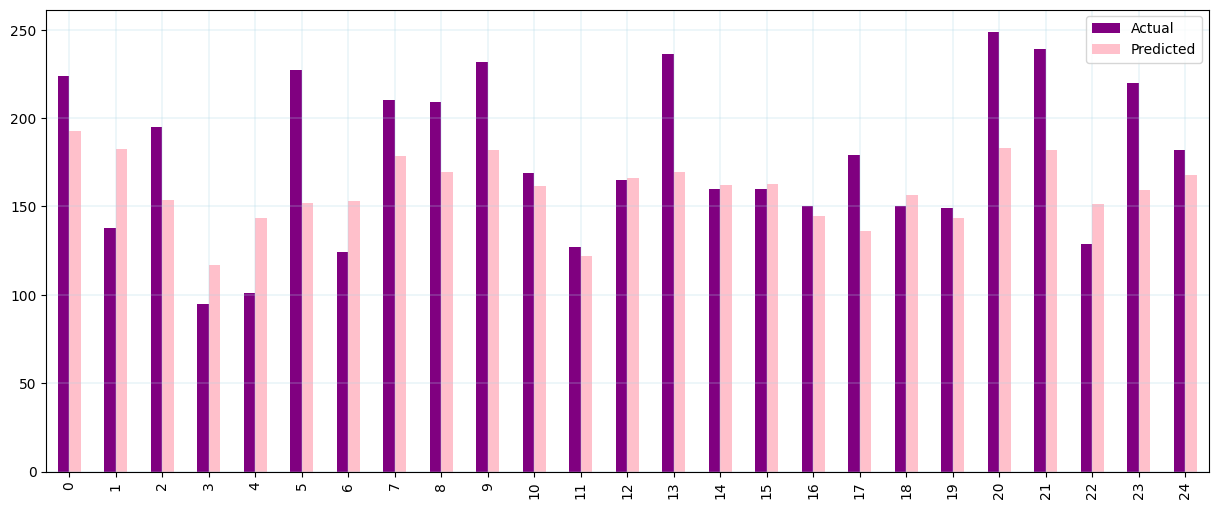

In [99]:
# comparison about actual and predicted values
first_25_preds = lr_predictions.head(25)
c = 'purple', 'pink'
first_25_preds.plot(kind='bar',figsize=(15,6), color=c)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='lightblue')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='yellow')
plt.show()

## Converting *price* into range of values and training the model

In [100]:
# conditions to put on prices without outliers
conditions = [
    (df3['price'] <= 100),
    (df3['price'] >100) & (df3['price'] <= 150),
    (df3['price'] >150) & (df3['price'] <= 200),
    (df3['price'] >200) & (df3['price'] <= 250),
]

# to avoid the chain warning
pd.options.mode.chained_assignment = None

# list of values to assigned to conditions
values = ['economic', 'low-mid', 'high-mid','high']

# new column to add the price range
df3['price_range'] = np.select(conditions, values)
df3.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,room_type_cat,availability_365,number_of_reviews_ltm,neighbourhood_cat,license_cat,price_range
2,37.75622,-122.39821,249,5,36,0.26000,1,0,202,7,25,430,high
17,37.71750,-122.39698,95,1,23,0.14000,2,2,365,5,0,170,economic
27,37.74159,-122.43159,165,5,68,0.75000,1,2,364,10,9,457,high-mid
29,37.76005,-122.42208,164,1,27,0.26000,2,2,0,1,15,398,high-mid
30,37.73871,-122.41167,190,4,25,0.17000,2,0,0,7,1,404,high-mid


In [101]:
df3['price_range'].value_counts()

low-mid     382
high-mid    353
high        223
economic     96
Name: price_range, dtype: int64

In [102]:
# encode the price classes
df3['price_range_cat'] = le.fit_transform(df3['price_range'])
df3.corr(numeric_only=True).style.background_gradient(cmap='magma')

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,room_type_cat,availability_365,number_of_reviews_ltm,neighbourhood_cat,license_cat,price_range_cat
latitude,1.000000,0.099021,0.109924,-0.011584,-0.097426,-0.161479,0.368642,0.299808,-0.002926,-0.154146,0.123185,-0.055878,-0.056008
longitude,0.099021,1.000000,-0.076344,0.017686,-0.152818,-0.254112,0.269355,0.182526,-0.002886,-0.221487,-0.278702,-0.013257,0.001022
price,0.109924,-0.076344,1.000000,0.088132,-0.140361,-0.101887,-0.139964,-0.334040,-0.042853,-0.103274,-0.003888,-0.015491,-0.338417
minimum_nights,-0.011584,0.017686,0.088132,1.000000,0.042622,-0.165858,-0.152007,-0.190228,-0.070885,-0.118428,0.058930,0.114014,-0.035244
number_of_reviews,-0.097426,-0.152818,-0.140361,0.042622,1.000000,0.408827,-0.252491,-0.033538,0.002020,0.531220,0.046338,0.264942,0.025853
reviews_per_month,-0.161479,-0.254112,-0.101887,-0.165858,0.408827,1.000000,-0.267343,-0.252255,-0.011814,0.800324,0.080889,0.030041,0.075889
calculated_host_listings_count,0.368642,0.269355,-0.139964,-0.152007,-0.252491,-0.267343,1.000000,0.428854,0.172641,-0.245669,0.027268,-0.076493,-0.076392
room_type_cat,0.299808,0.182526,-0.334040,-0.190228,-0.033538,-0.252255,0.428854,1.000000,0.119401,-0.218638,0.022530,-0.063434,0.033485
availability_365,-0.002926,-0.002886,-0.042853,-0.070885,0.002020,-0.011814,0.172641,0.119401,1.000000,-0.022225,0.049886,0.031854,-0.081687
number_of_reviews_ltm,-0.154146,-0.221487,-0.103274,-0.118428,0.531220,0.800324,-0.245669,-0.218638,-0.022225,1.000000,0.041950,0.075438,0.060768


In [103]:
# conditions to put on prices with outliers
conditions = [
    (df4['price'] <= 100),
    (df4['price'] >100) & (df4['price'] <= 150),
    (df4['price'] >150) & (df4['price'] <= 200),
    (df4['price'] >200) & (df4['price'] <= 250),
    (df4['price']>250)
]

# to avoid the chain warning
pd.options.mode.chained_assignment = None

# list of values to assigned to conditions
values = ['economic', 'low-mid', 'high-mid','high', 'very-high']

# new column to add the price range
df4['price_range'] = np.select(conditions, values)
df4.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,room_type_cat1,availability_365,number_of_reviews_ltm,neighbourhood_cat1,license_cat1,price_range
0,37.75635,-122.42864,1250,5,34,0.23000,1,0,80,2,18,1137,very-high
1,37.72369,-122.42865,79,2,149,1.92000,1,2,196,20,7,2265,economic
2,37.75622,-122.39821,249,5,36,0.26000,1,0,202,7,26,1367,high
3,37.75884,-122.42232,125,30,196,1.41000,1,0,149,4,16,1136,low-mid
4,37.76111,-122.42082,70,30,2,0.02000,1,0,0,0,16,1136,economic


In [104]:
df4['price_range'].value_counts()

economic     2495
very-high    1879
low-mid      1786
high-mid     1186
high          710
Name: price_range, dtype: int64

In [105]:
# encode the price classes on data with outliers
df4['price_range_cat'] = le.fit_transform(df4['price_range'])
df4.corr(numeric_only=True).style.background_gradient(cmap='magma')

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,room_type_cat1,availability_365,number_of_reviews_ltm,neighbourhood_cat1,license_cat1,price_range_cat
latitude,1.000000,0.234246,0.064520,0.059398,-0.146819,-0.185484,0.267415,0.046160,0.083262,-0.159879,0.122822,-0.095888,0.111571
longitude,0.234246,1.000000,0.026735,0.053799,-0.169459,-0.206770,0.178578,0.023027,0.040634,-0.188293,-0.169306,-0.080815,0.055763
price,0.064520,0.026735,1.000000,-0.017007,-0.045045,-0.052207,-0.000118,-0.006443,-0.043299,-0.046302,-0.039183,-0.036390,0.162281
minimum_nights,0.059398,0.053799,-0.017007,1.000000,-0.130518,-0.179851,-0.021932,-0.005486,0.135550,-0.167415,0.051411,0.020917,-0.112909
number_of_reviews,-0.146819,-0.169459,-0.045045,-0.130518,1.000000,0.703597,-0.174356,0.023349,-0.110225,0.700063,0.007611,0.186839,-0.009179
reviews_per_month,-0.185484,-0.206770,-0.052207,-0.179851,0.703597,1.000000,-0.198389,0.007919,-0.154880,0.890342,0.024376,0.081915,-0.008312
calculated_host_listings_count,0.267415,0.178578,-0.000118,-0.021932,-0.174356,-0.198389,1.000000,0.187776,0.204393,-0.175058,0.038418,-0.032867,-0.235079
room_type_cat1,0.046160,0.023027,-0.006443,-0.005486,0.023349,0.007919,0.187776,1.000000,0.056261,0.012463,-0.011477,-0.080472,-0.414266
availability_365,0.083262,0.040634,-0.043299,0.135550,-0.110225,-0.154880,0.204393,0.056261,1.000000,-0.142933,0.072082,-0.005158,-0.047053
number_of_reviews_ltm,-0.159879,-0.188293,-0.046302,-0.167415,0.700063,0.890342,-0.175058,0.012463,-0.142933,1.000000,0.022357,0.100058,-0.021172


### finding feature importance using ensemble learning

feature: latitude, importance: 0.05828061327338219
feature: longitude, importance: 0.09227431565523148
feature: price, importance: 0.06941995769739151
feature: minimum_nights, importance: 0.07629278302192688
feature: number_of_reviews, importance: 0.08572781831026077
feature: reviews_per_month, importance: 0.11972127854824066
feature: calculated_host_listings_count, importance: 0.1475641280412674
feature: room_type_cat, importance: 0.08302746713161469
feature: availability_365, importance: 0.10453218966722488
feature: number_of_reviews_ltm, importance: 0.08107919245958328
feature: neighbourhood_cat, importance: 0.08208025246858597


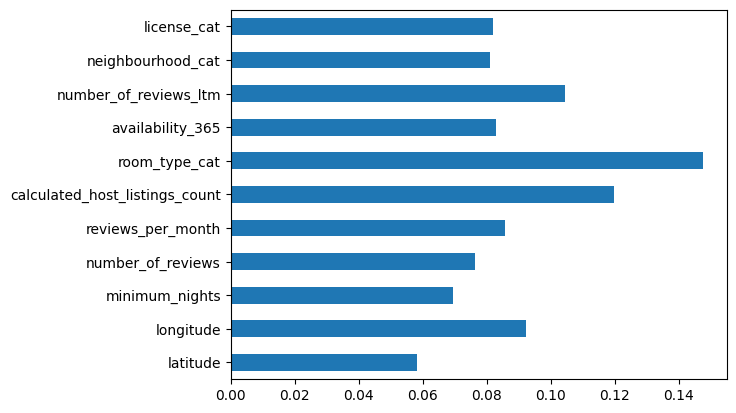

In [106]:
# feature importance without outliers

X_ = df3.drop(['price_range_cat', 'price_range', 'price'],axis=1)
Y = df3['price_range_cat']
data_dmatrix = xgboost.DMatrix(data=X_, label=Y, enable_categorical=True)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_, Y, test_size=0.2, random_state=0)

xg_reg = XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train1,y_train1)

for feat, importance in zip(df3.columns, xg_reg.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

# plot the features
(pd.Series(xg_reg.feature_importances_, index=X_.columns).plot(kind='barh'))

preds = xg_reg.predict(X_test1)

From the above values and graph, it is seen that, now all variables have the importance with the target varaible.

From the above two regressors, the value of MAE, MSE, RMSE are similar. Now, to improve the model, the price column is created as categorical with price range.

The minimum value of price is **95** and maximum is **249**, so the groups are created in the range of 50.

## Claasification with KNN

The classification model is trained here, because now the target variable is categorical.

In [107]:
df5 = df3.drop(['price_range', 'price'], axis=1)
X1 = df5.iloc[:, :-1].values
y1 = df5['price_range_cat'].values

x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=35)
print(x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape)

(843, 11) (211, 11) (843,) (211,)


In [108]:
knn = KNeighborsClassifier(n_neighbors=1)

# normalize the values
ss = StandardScaler()
ss.fit(x_train1)

x_train1 = ss.transform(x_train1)
x_test1 = ss.transform(x_test1)

knn.fit(x_train1, y_train1)

KNeighborsClassifier(n_neighbors=1)

In [109]:
print(x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape)


(843, 11) (211, 11) (843,) (211,)


In [110]:
# Predicted classes
y_preds_knn=knn.predict(x_test1)

knn_predictions = pd.DataFrame({'Actual': y_test1.flatten(), 'Predicted': y_preds_knn.flatten()})
knn_predictions

,Actual,Predicted
0,1,2
1,3,2
2,2,1
3,0,3
4,3,3
...,...,...
206,3,3
207,1,2
208,2,2
209,2,2


In [111]:
# accuracy of the model
print(knn.score(x_test1, y_test1))

0.41232227488151657


### KNN model evaluation

In [112]:
mae = metrics.mean_absolute_error(y_test1, y_preds_knn)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test1, y_preds_knn)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test1, y_preds_knn))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:0.8293838862559242
Mean Square Error:1.4739336492890995
Root Mean Square Error:1.2140566911347672


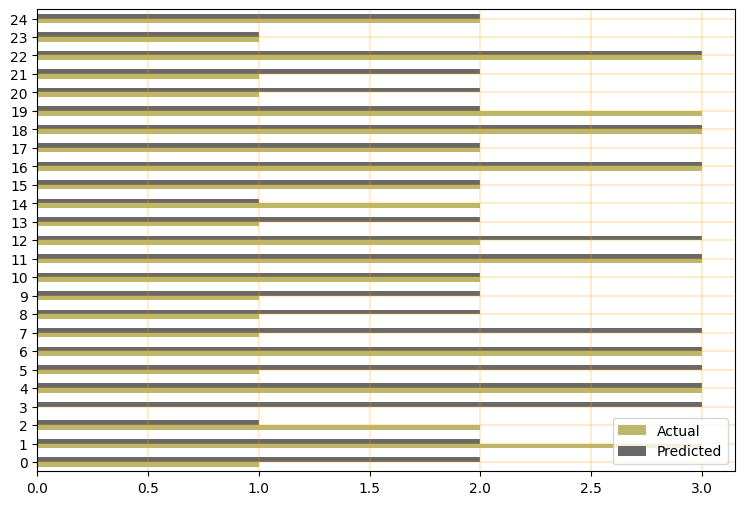

In [113]:
#comparison
first_25_preds = knn_predictions.head(25)
c2='darkkhaki', 'dimgray'
first_25_preds.plot(kind='barh',figsize=(9,6), color=c2)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='orange')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Classification using SVM

In [114]:
svc = SVC(kernel='rbf')

svc.fit(x_train1, y_train1)

SVC()

In [115]:
y_preds_svc = svc.predict(x_test1)

svc_predictions = pd.DataFrame({'Actual': y_test1.flatten(), 'Predicted': y_preds_svc.flatten()})
svc_predictions

,Actual,Predicted
0,1,2
1,3,1
2,2,3
3,0,3
4,3,3
...,...,...
206,3,3
207,1,2
208,2,2
209,2,2


In [116]:
# accuracy of the model
print(svc.score(x_test1, y_test1))

0.4834123222748815


### SVM classification model evaluation

In [117]:
mae = metrics.mean_absolute_error(y_test1, y_preds_svc)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test1, y_preds_svc)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test1, y_preds_svc))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:0.6919431279620853
Mean Square Error:1.1563981042654028
Root Mean Square Error:1.0753595232597342


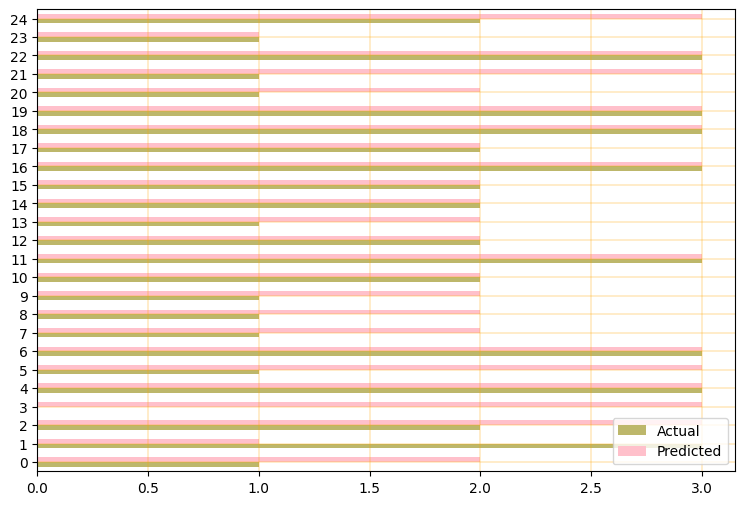

In [118]:
#comparison
first_25_preds = svc_predictions.head(25)
c2='darkkhaki', 'pink'
first_25_preds.plot(kind='barh',figsize=(9,6), color=c2)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='orange')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## GridSearchCV - Hyperparamter Tuning and Cross Validation

In [119]:
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1, 'scale']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, n_jobs=5, verbose=1)
grid.fit(x_train1, y_train1)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
The best parameters are {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} with a score of 0.46


In [120]:
y_preds_grid = grid.predict(x_test1)

grid_predictions = pd.DataFrame({'Actual': y_test1.flatten(), 'Predicted': y_preds_grid.flatten()})
grid_predictions

,Actual,Predicted
0,1,2
1,3,1
2,2,3
3,0,3
4,3,3
...,...,...
206,3,3
207,1,2
208,2,2
209,2,2


In [121]:
print(grid.score(x_test1, y_test1))

0.4928909952606635


### GridsearchCv and SVM classification model evaluation

In [122]:
mae = metrics.mean_absolute_error(y_test1, y_preds_grid)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test1, y_preds_grid)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test1, y_preds_grid))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:0.6824644549763034
Mean Square Error:1.146919431279621
Root Mean Square Error:1.0709432437247182


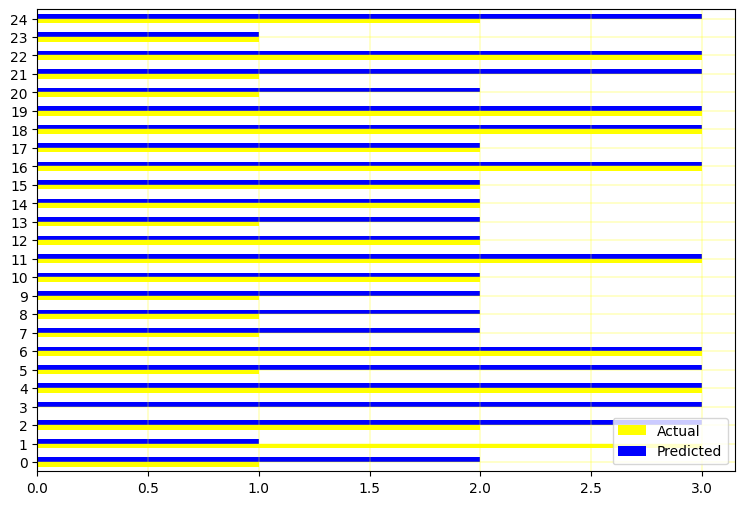

In [123]:
#comparison
first_25_preds = grid_predictions.head(25)
c2='yellow', 'blue'
first_25_preds.plot(kind='barh',figsize=(9,6), color=c2)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='yellow')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='blue')
plt.show()

## SVM on data with outlier

In [124]:
df6 = df4.drop(['price_range', 'price'], axis=1)
X2 = df6.iloc[:, :-1].values
y2 = df6['price_range_cat'].values

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=35)
print(x_train2.shape, x_test2.shape, y_train2.shape, y_test2.shape)

(6444, 11) (1612, 11) (6444,) (1612,)


In [125]:
svc2 = SVC(kernel='rbf')

svc2.fit(x_train2, y_train2)

SVC()

In [126]:
y_preds_svc2 = svc2.predict(x_test2)

svc_predictions = pd.DataFrame({'Actual': y_test2.flatten(), 'Predicted': y_preds_svc2.flatten()})
svc_predictions

,Actual,Predicted
0,2,0
1,4,0
2,0,3
3,4,4
4,3,0
...,...,...
1607,0,0
1608,4,0
1609,3,3
1610,2,0


In [127]:
svc2.score(x_test2, y_test2)

0.34739454094292804

### SVM classification model evaluation with outliers

In [128]:
mae = metrics.mean_absolute_error(y_test2, y_preds_svc2)
print(f"Mean Absolute Error:{mae}")

mse = metrics.mean_squared_error(y_test2, y_preds_svc2)
print(f"Mean Square Error:{mse}")

rmse = np.sqrt(metrics.mean_squared_error(y_test2, y_preds_svc2))
print(f"Root Mean Square Error:{rmse}")


Mean Absolute Error:1.7673697270471465
Mean Square Error:5.5390818858560795
Root Mean Square Error:2.353525416445737


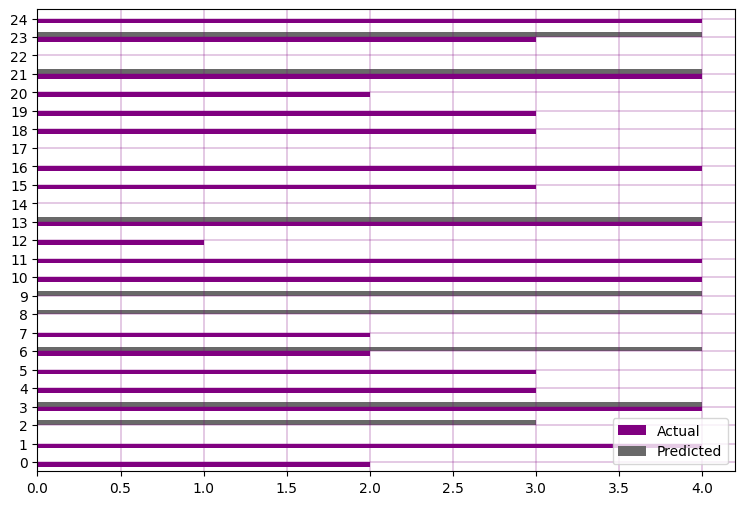

In [129]:
#comparison
first_25_preds = svc_predictions.head(25)
c2='purple', 'dimgray'
first_25_preds.plot(kind='barh',figsize=(9,6), color=c2)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='purple')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='dimgray')
plt.show()

## GridsearchCV - Hyperparameter Tuning and Cross Validation with Outliers

In [ ]:
# IT TAKES TOO MUCH TIME TO FIT
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1, 'scale']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, n_jobs=5, verbose=1)
grid.fit(x_train2, y_train2)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [ ]:
y_preds_grid_o = grid.predict(x_test2)

grid_predictions_o = pd.DataFrame({'Actual': y_test2.flatten(), 'Predicted': y_preds_grid_o.flatten()})
grid_predictions_o

In [ ]:
print(grid.score(x_test2, y_test2))

## interpretation

In [ ]:
! pip install shap
import shap

In [ ]:
explainer = shap.KernelExplainer(svc.predict, X_train1.iloc[0:10])
shap_values = explainer.shap_values(X_test1.iloc[0:5])

In [ ]:
# Inspect first row
shap.initjs()
# print("Original y-value: ", y_test1.iloc[0])
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:])